# Retrieve a Eurobis dataset
Imagine you are interested in occurrence data, for instance this zooplankton dataset on [Eurobis](https://www.eurobis.org/imis?module=dataset&dasid=4687). You can also find this dataset via these portals:
- [IPT](https://www.vliz.be/nl/imis?module=dataset&dasid=4685&printversion=1&dropIMIStitle=1)
- [EMODnet](https://emodnet.ec.europa.eu/geonetwork/srv/eng/catalog.search#/metadata/6d617269-6e65-696e-666f-000000004687)
- [LifeWatch](https://rshiny.lifewatch.be/flowcam-data/)

This tutorial will illustrate how to get to this data via the DTO.
## 0. Setup environment
#### Requirements

In [1]:
packages = ["contextily",
            "pandas",
            "geopandas",
            "matplotlib",
            "pyarrow"]

#### Install packages

In [ ]:
for package in packages:
    !pip install {package}

#### Load packages

In [3]:
import contextily
import pyarrow.parquet as pq
import pyarrow.fs
import pyarrow.dataset as ds
import pyarrow.compute as pc
import pyarrow.fs
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import contextily as ctx
from shapely.geometry import Point

## 1. Open the occurences dataset
#### connect to the S3 object storage 
You need following information:

- Host: s3.waw3-1.cloudferro.com
- Bucket: emodnet
- Key: biology/eurobis_occurrence_data/eurobis_occurrences_geoparquet_2024-10-01.parquet

In [4]:
host = "s3.waw3-1.cloudferro.com"
bucket_name = "emodnet"
key = "biology/eurobis_occurrence_data/eurobis_occurrences_geoparquet_2024-10-01.parquet"

s3 = pyarrow.fs.S3FileSystem(endpoint_override=host)
s3_path = f"{bucket_name}/{key}"

#### Open file and inspect the schema
Open the file. Notice this is not equal to loading the data. The entire dataset contains way to many records to load at once, we will filter en load in a later step.

In [5]:
with s3.open_input_file(s3_path) as file:
    table = pq.read_table(file)

View the schema

In [6]:
print(table.schema)

occurrenceid: int32
datasetid: int32
observationdate: timestamp[us, tz=UTC]
longitude: double
latitude: double
scientificname: string
aphiaid: int32
scientificname_accepted: string
aphiaidaccepted: int32
taxonrank: int32
geometry: binary
  -- field metadata --
  ARROW:extension:metadata: '      crs�   GEOGCS["WGS 84",DATUM["WGS_19' + 198
  ARROW:extension:name: 'geoarrow.wkb'
-- schema metadata --
geo: '{"version":"0.3.0","primary_column":"geometry","columns":{"geometry' + 340


## 2. Filter the data
We will filter for copepods (apiaID 1080 near the Flemish coast (latitude 51-51.5; longitude 2.5-3.3).

In [7]:
dataset = ds.dataset(s3_path, filesystem=s3, format="parquet")
filtered_table = dataset.to_table(
    filter=(
        (pc.field("aphiaid") == 1080) &
        (pc.field("latitude") >= 51) &
        (pc.field("latitude") <= 51.5) &
        (pc.field("longitude") >= 2.5) &
        (pc.field("longitude") <= 3.3)
    )
)

#### Convert to Pandas DataFrame

In [8]:
df = filtered_table.to_pandas()

See how many records in this dataframe

In [9]:
print(f"{len(df)=}")

len(df)=1477


Print some records to see the data.

In [10]:
for line in df.head(10).itertuples():
    print(line)

Pandas(Index=0, occurrenceid=38279854, datasetid=67, observationdate=Timestamp('1986-04-02 00:00:00+0000', tz='UTC'), longitude=2.5, latitude=51.25, scientificname='Copepoda', aphiaid=1080, scientificname_accepted='Copepoda', aphiaidaccepted=1080, taxonrank=60, geometry=b'\x01\x01\x00\x00\x00\x00\x00\x00\x00\x00\x00\x04@\x00\x00\x00\x00\x00\xa0I@')
Pandas(Index=1, occurrenceid=119851535, datasetid=4688, observationdate=Timestamp('2020-06-23 00:00:00+0000', tz='UTC'), longitude=2.50042117, latitude=51.3342685, scientificname='Copepoda', aphiaid=1080, scientificname_accepted='Copepoda', aphiaidaccepted=1080, taxonrank=60, geometry=b'\x01\x01\x00\x00\x00*\x02{\xd0\xdc\x00\x04@\x9f\xcaiO\xc9\xaaI@')
Pandas(Index=2, occurrenceid=119862435, datasetid=4688, observationdate=Timestamp('2021-09-28 00:00:00+0000', tz='UTC'), longitude=2.50075983, latitude=51.33369755, scientificname='Copepoda', aphiaid=1080, scientificname_accepted='Copepoda', aphiaidaccepted=1080, taxonrank=60, geometry=b'\x01\x

You may notice not all fields are available. In fact this dataset only contains occurences and no count or densities. This is something that will be fixed in e next update.

## 3.Plotting the data
Lets visualize the data for better understanding.

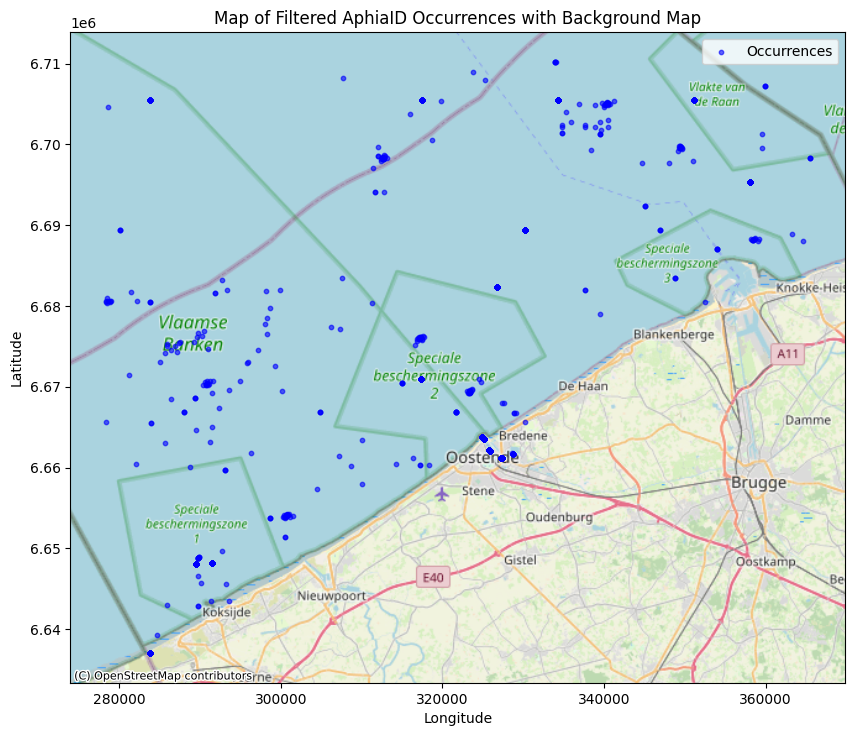

In [11]:
gdf = gpd.GeoDataFrame(
    df,
    geometry=gpd.points_from_xy(df.longitude, df.latitude),
    crs="EPSG:4326"  # WGS84 coordinate system
)
fig, ax = plt.subplots(figsize=(10, 10))
gdf = gdf.to_crs(epsg=3857)  # Reproject to Web Mercator for compatibility with contextily
gdf.plot(ax=ax, color="blue", markersize=10, alpha=0.6, label="Occurrences")
ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik, zoom=10)
ax.set_title("Map of Filtered AphiaID Occurrences with Background Map")
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
plt.legend()
plt.show()

## 4. Conclusion
This notebook demonstrated how to reach the Eurobis data via EDITO data lake. All occurence datasets are merged in a single parquet file in the data lake. So its not a good practice to search for a specific dataset. The way to go is to filter on AphiaID and lat/lon and retrieve all available occurences. 